In [1]:
import pandas as pd
import pathlib
import pandas_profiling
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
power_pd = pd.read_csv('./household_power_consumption.csv')

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print("Analyzing missing values")
len(power_pd) - power_pd.count()

Analyzing missing values


Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [4]:
power_pd["Date"] = pd.to_datetime(power_pd["Date"], format='%d/%m/%Y')
power_pd["Time"] = pd.to_datetime(power_pd["Time"], format='%H:%M:%S').dt.time

In [27]:
for column in power_pd.columns[2:]:
    power_pd[column]= pd.to_numeric(power_pd[column], errors='coerce').interpolate()

In [29]:
len(power_pd) - power_pd.count()

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Seems that `None` values were only in some particular rows for all columns, now our data is cleaned

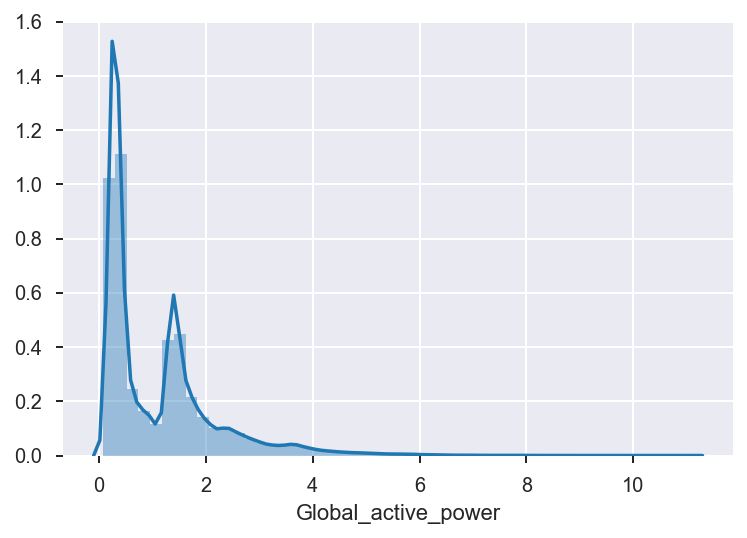

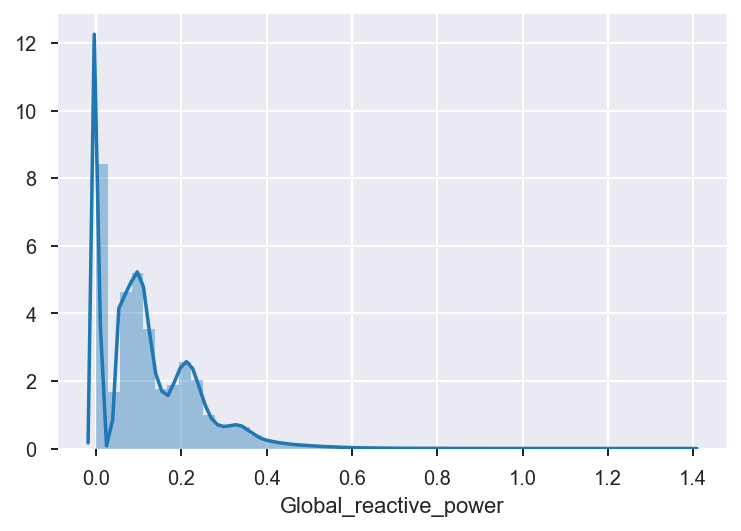

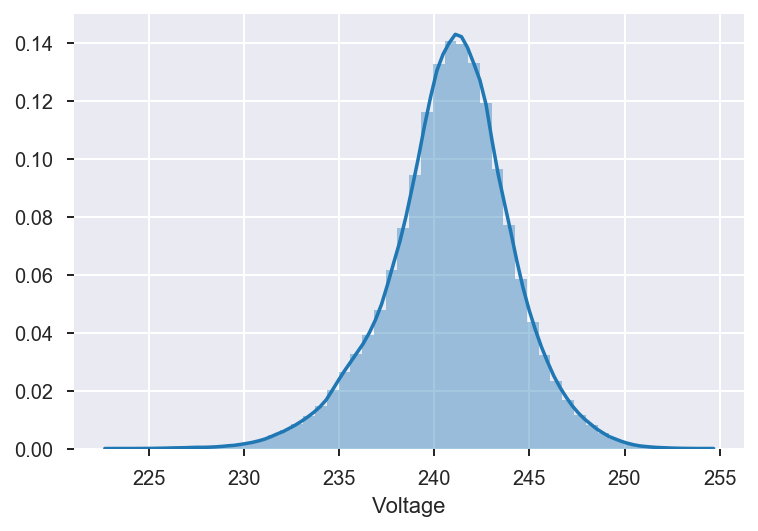

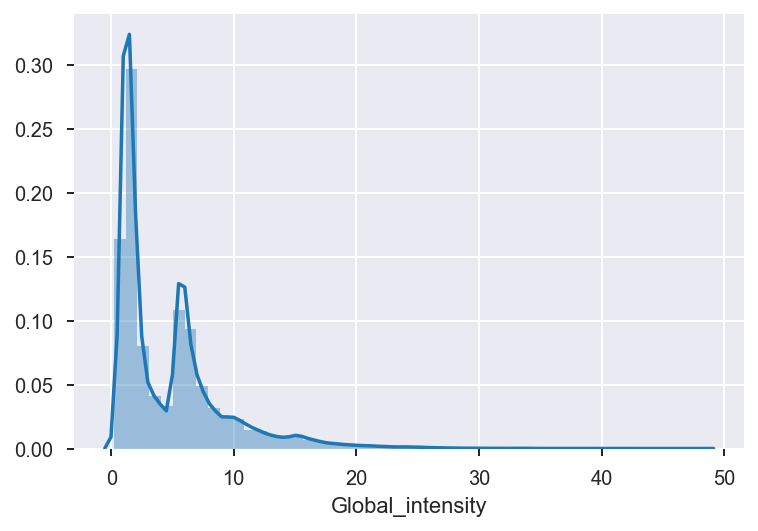

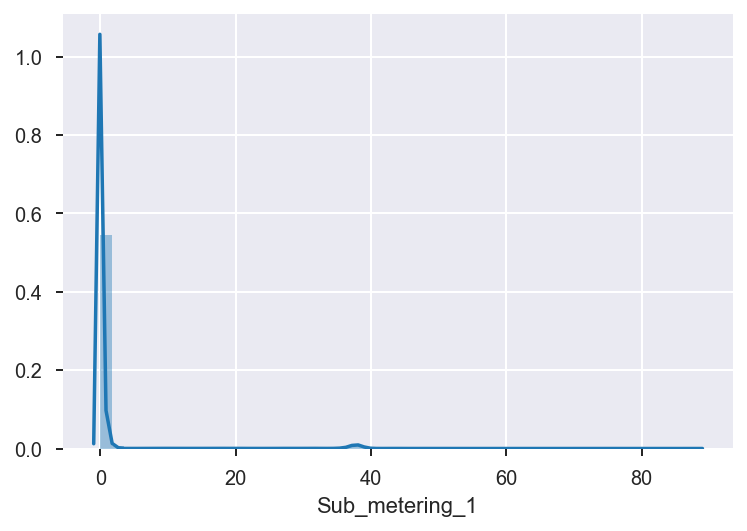

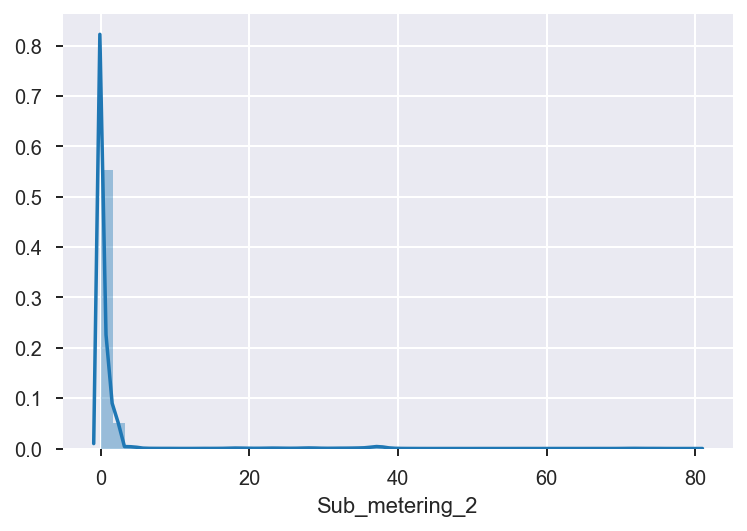

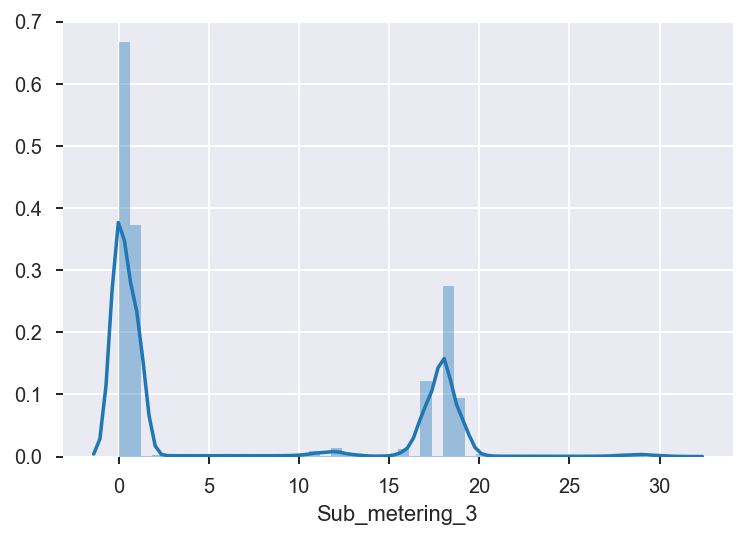

In [30]:
for column in numerical_columns.columns:
    sns.distplot(power_pd[column])
    plt.show()

## Lets analyze `Global_active_power` change over time

In [31]:
daily_stats = power_pd.groupby('Date').agg({'Global_active_power':'mean'})

In [32]:
daily_stats.reset_index(inplace=True)

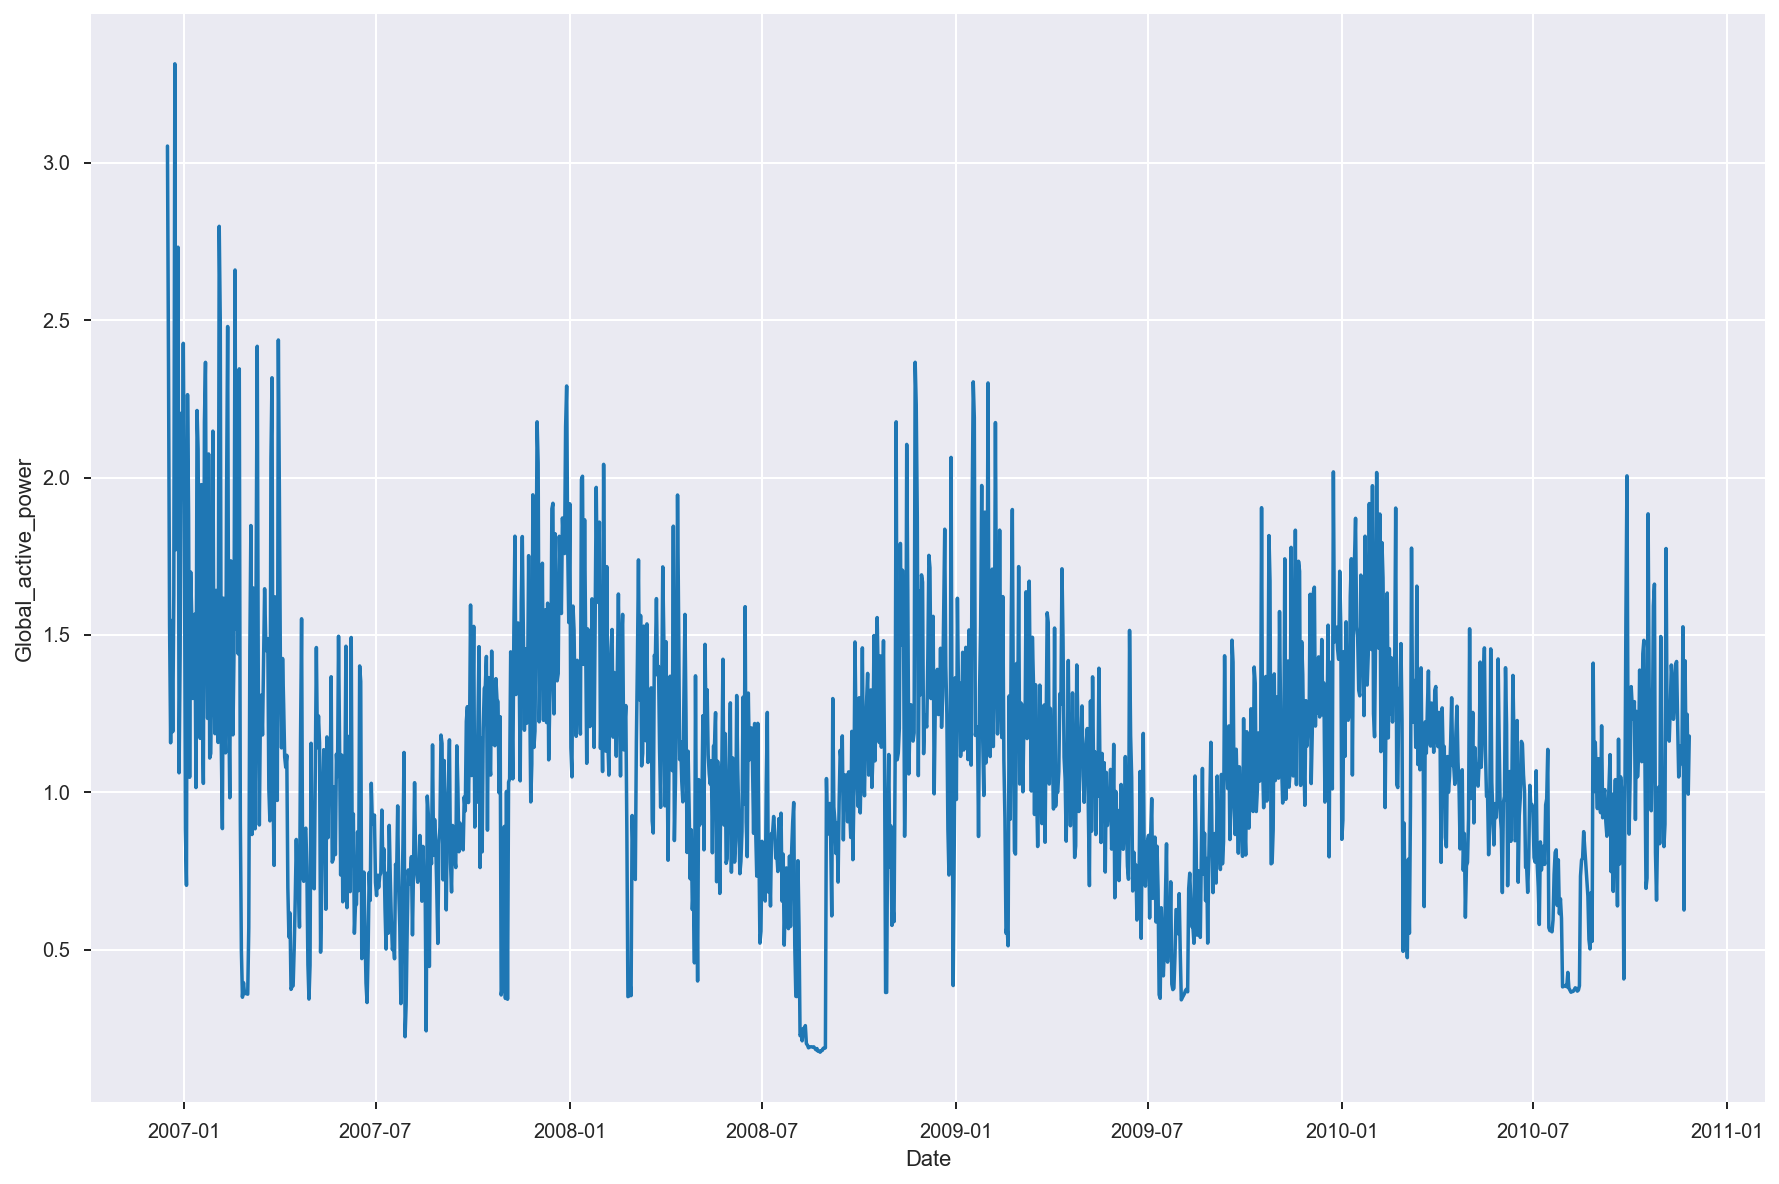

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x='Date',y='Global_active_power', data = daily_stats )

In [34]:
# Lets smooth our values using exponential moving average for the last 15day interval
daily_stats['ema_GAP'] = daily_stats['Global_active_power'].ewm(span=15).mean()

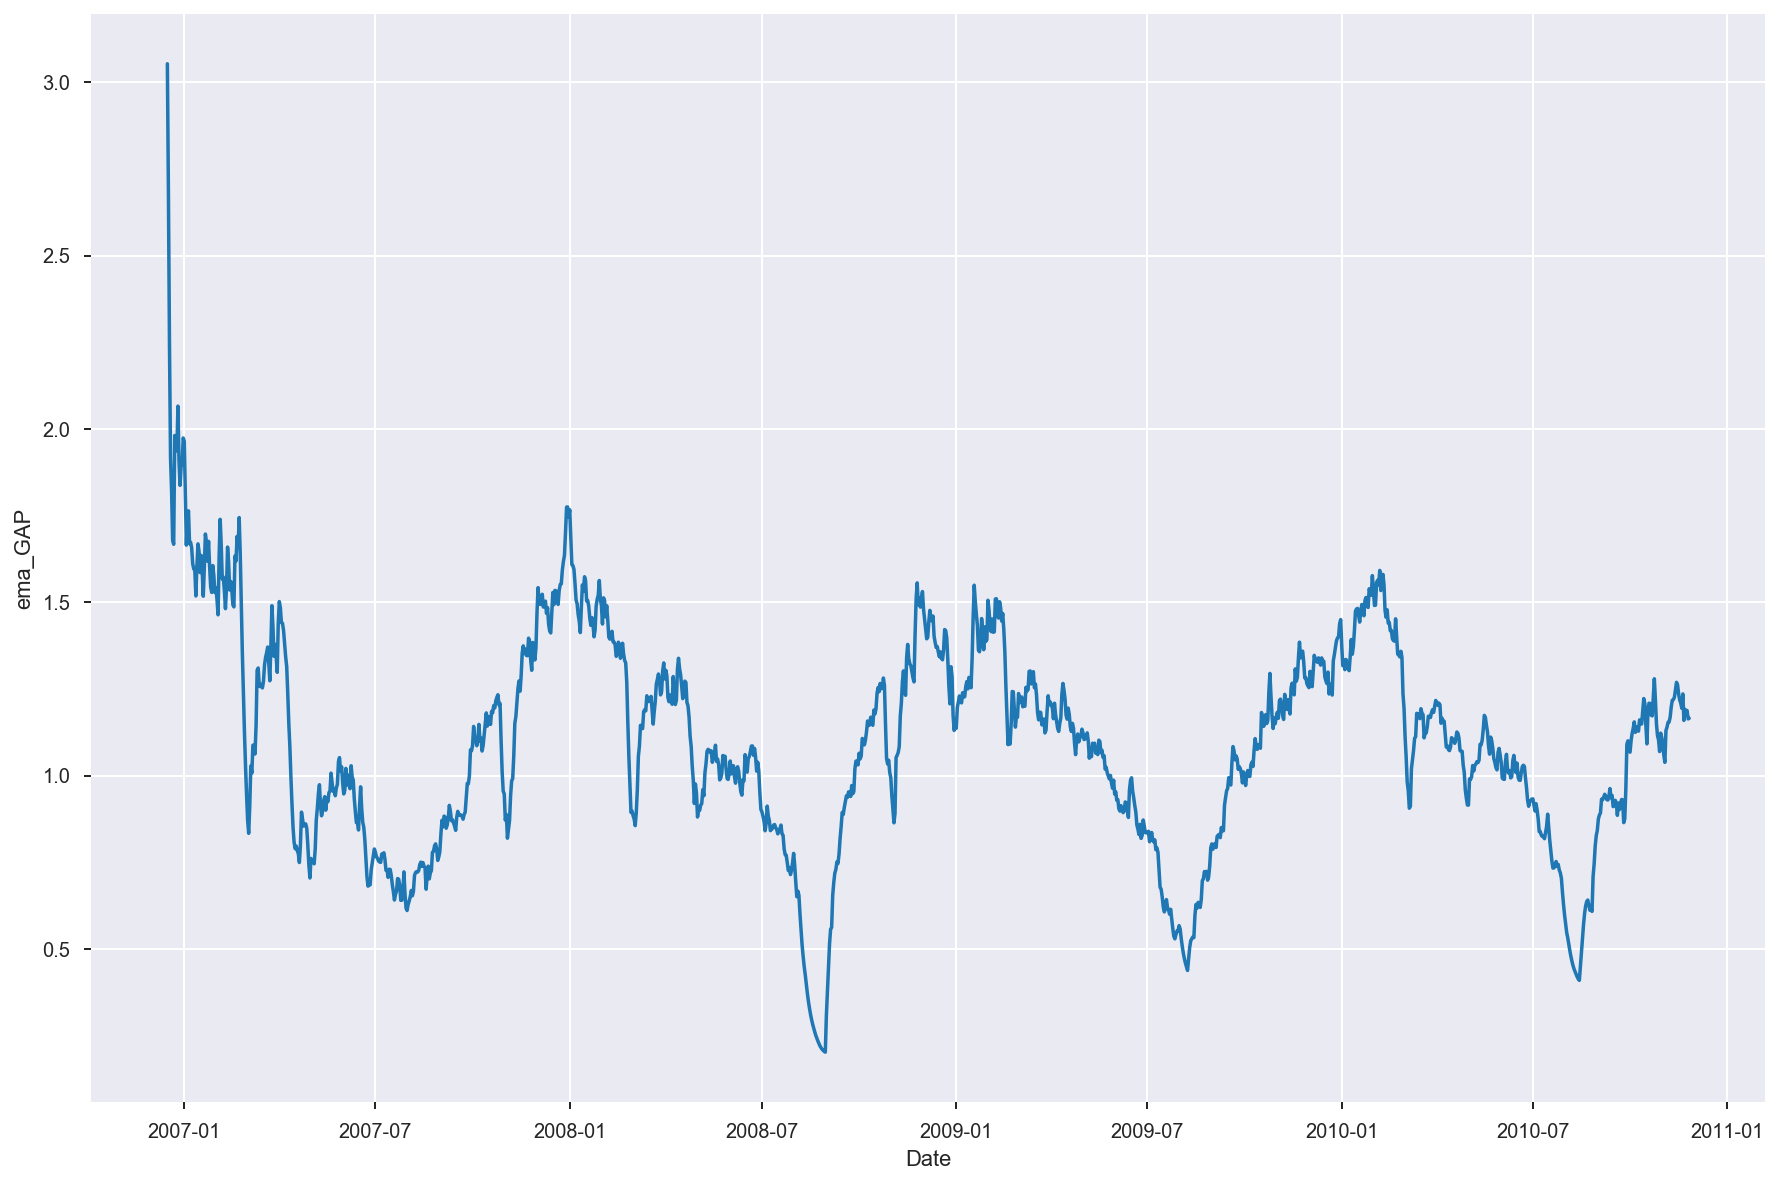

In [35]:
plt.subplots(figsize=(15,10))
sns.lineplot(x='Date',y='ema_GAP', data = daily_stats)

### Pretty obvious seasonal pattern, as the winter comes the global `Global_active_power` rises and vice versa. (Everybody wants to keep their houses warm). Also, there is no substantial difference in consumption rate over time.

### Lets take a look at monthly stats to capture downward trend

In [36]:
power_pd['year_and_month'] = power_pd.Date.dt.year.astype(str).str.cat(power_pd.Date.dt.month.astype(str), sep='-')

In [37]:
monthly_stats = power_pd.groupby('year_and_month').agg({'Global_active_power':'mean'})

In [38]:
monthly_stats.reset_index(inplace=True)

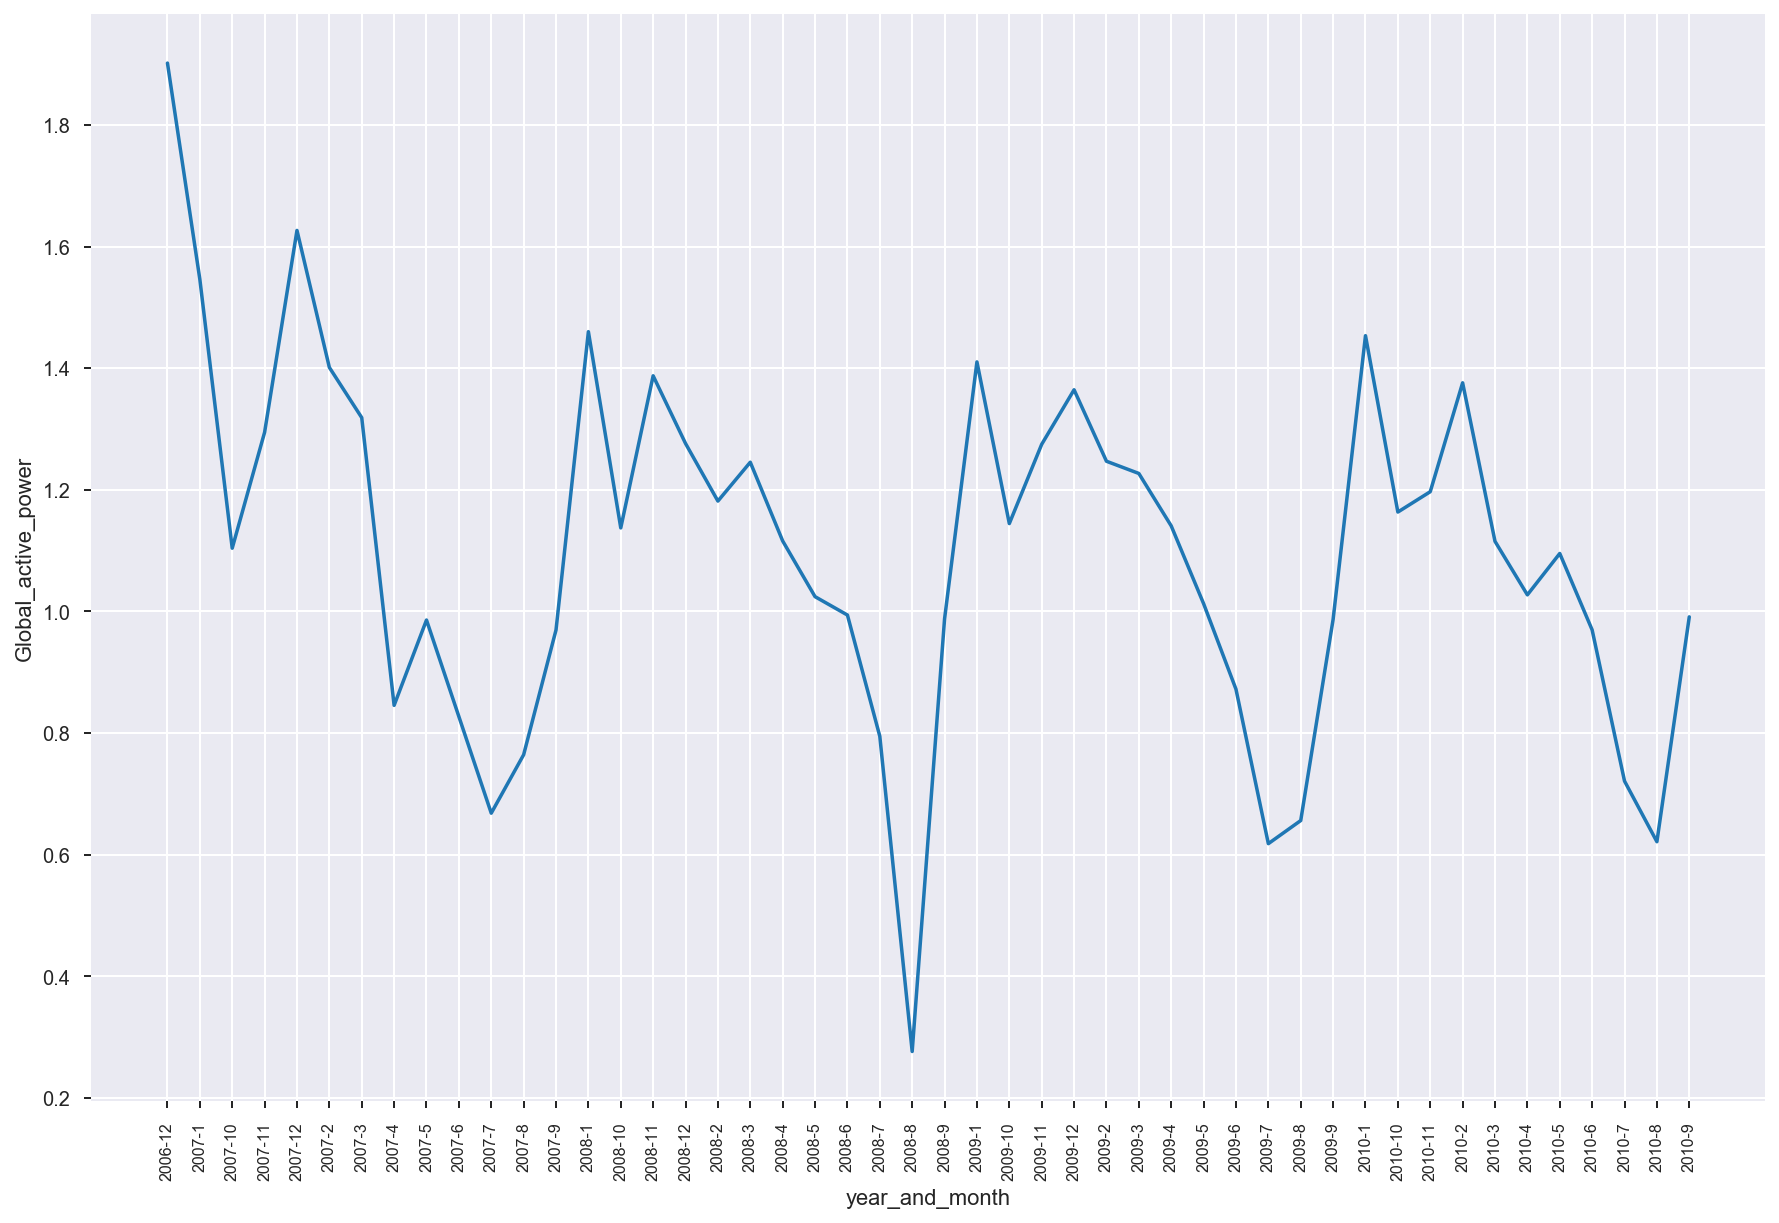

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
plt.xticks(fontsize=8, rotation=90)
sns.lineplot(x='year_and_month', y='Global_active_power', data = monthly_stats, ax=ax )

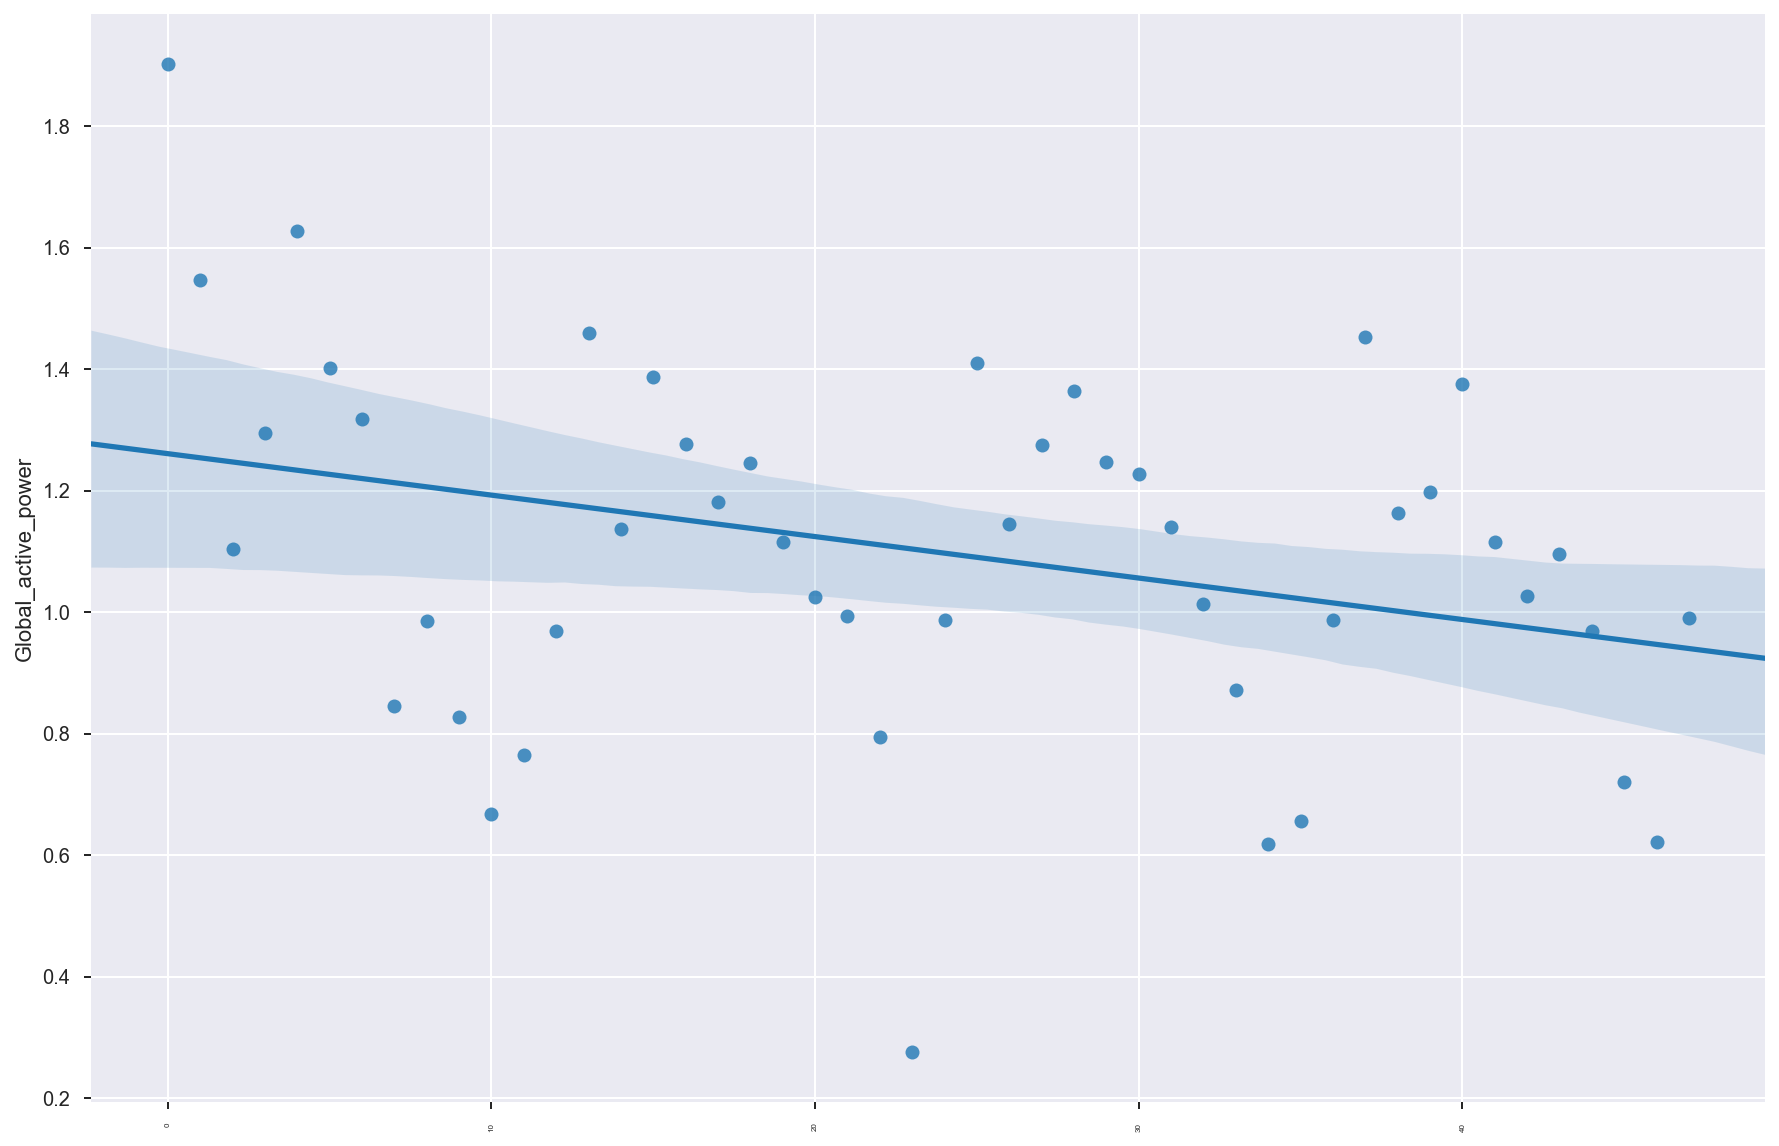

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
plt.xticks(fontsize=4, rotation=90)
sns.regplot(x=list(range(len(monthly_stats))),y='Global_active_power', data = monthly_stats)

### Seems that we have a slight downward pattern

### Plot data in specified time_interval ```(2008-02-01 and 2008-02-02) ```

In [49]:
filtered_data = power_pd_cleaned[(power_pd_cleaned.Date>="2008-02-01") & (power_pd_cleaned.Date<"2008-02-02")]

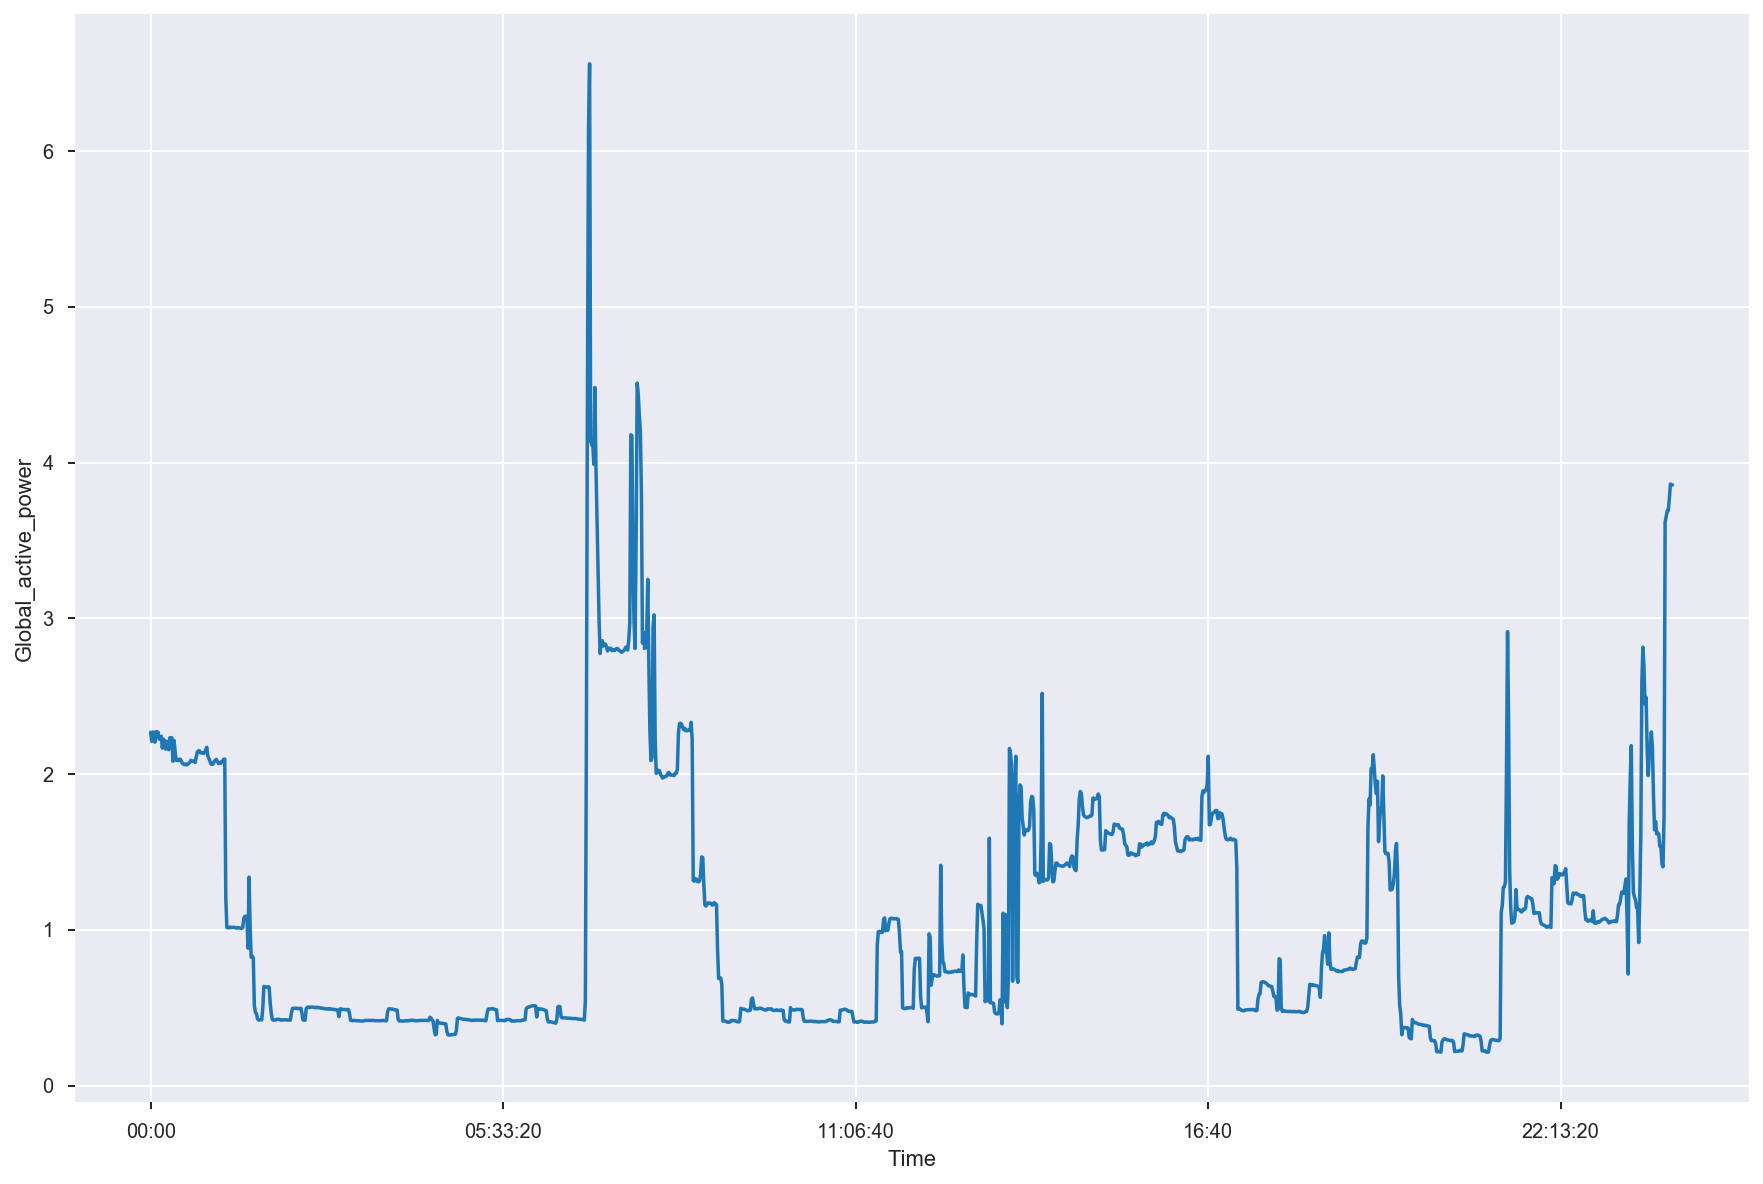

In [48]:
plt.subplots(figsize=(15,10))
sns.lineplot(x='Time',y='Global_active_power', data = filtered_data)

In [66]:
time_indexed = filtered_data[['Time','Sub_metering_1','Sub_metering_2','Sub_metering_3']]
# time_indexed.set_index('Time',inplace=True)

In [71]:
melted_df = time_indexed.melt(id_vars=['Time'])

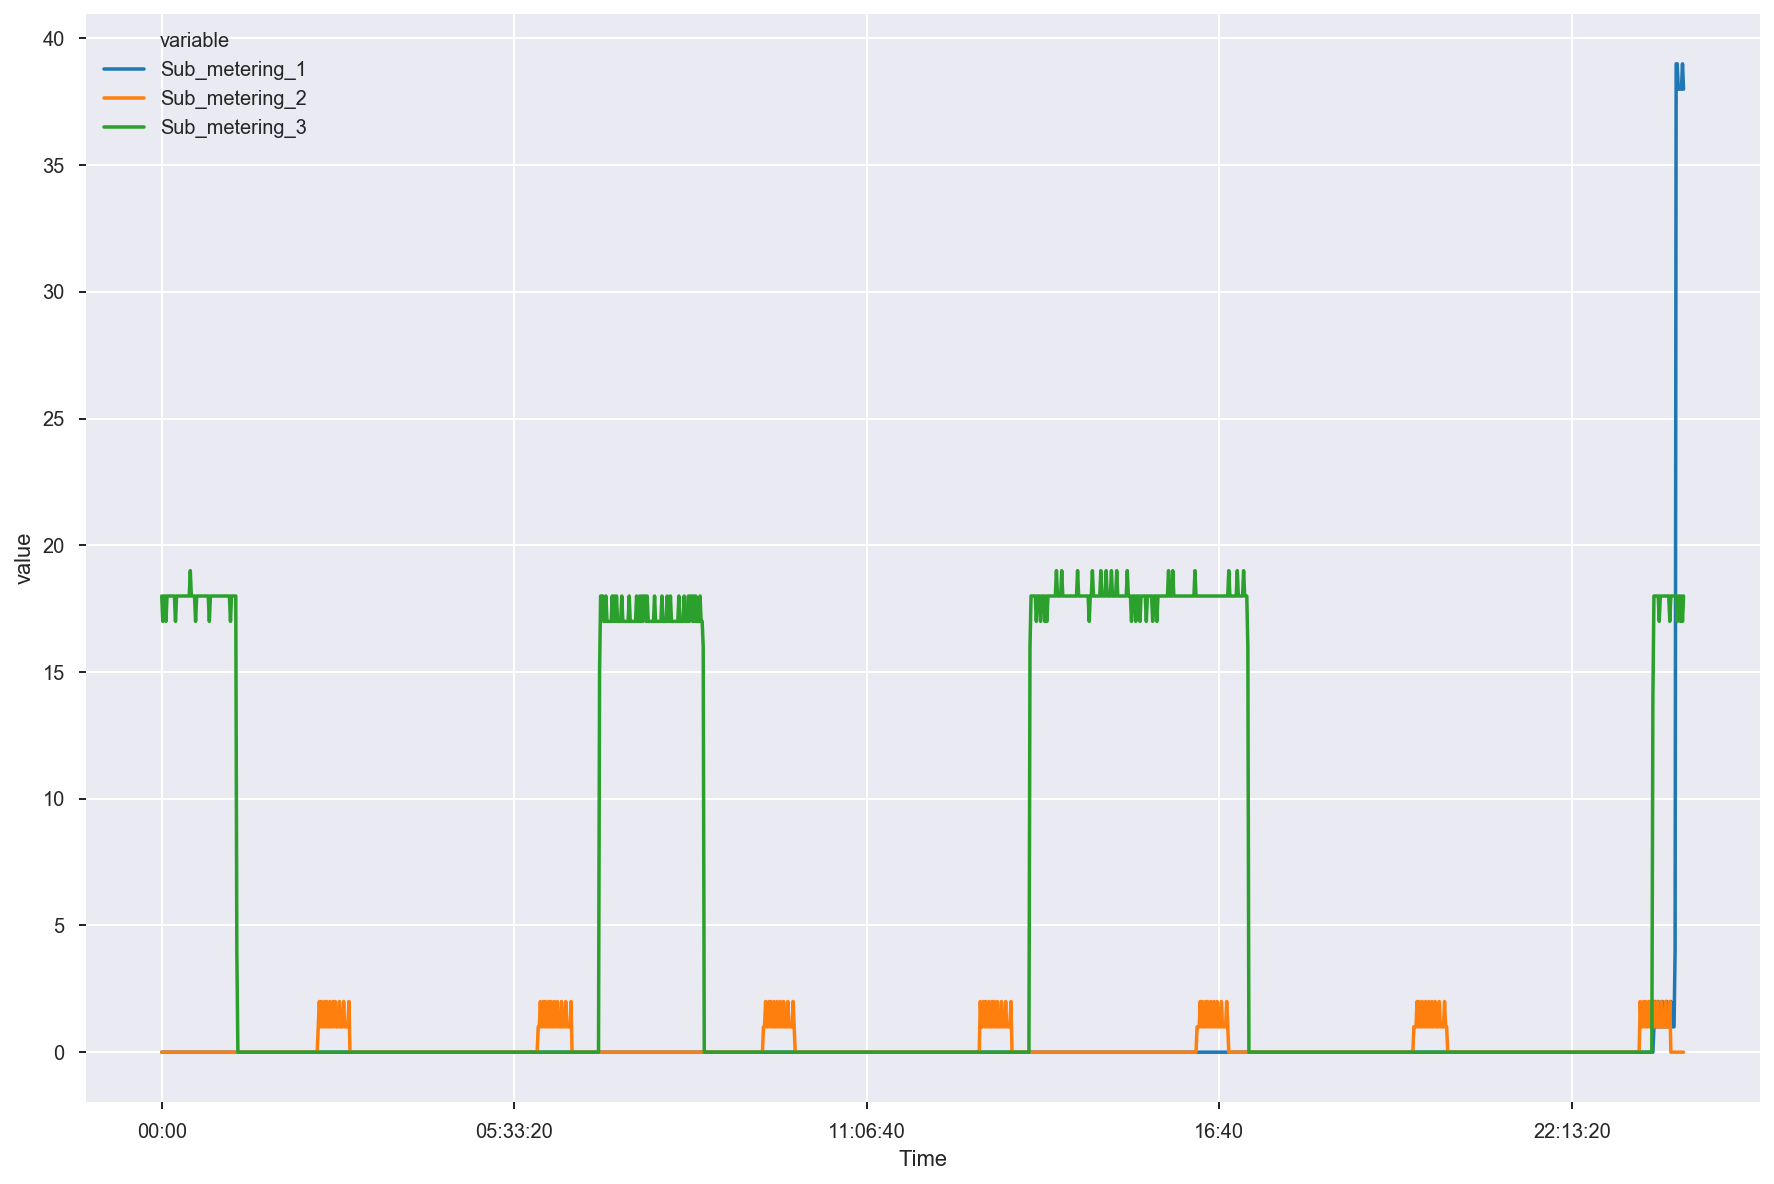

In [79]:
plt.subplots(figsize=(15,10))
#blue one 
sns.lineplot(x='Time',y='value',hue='variable',data = melted_df)

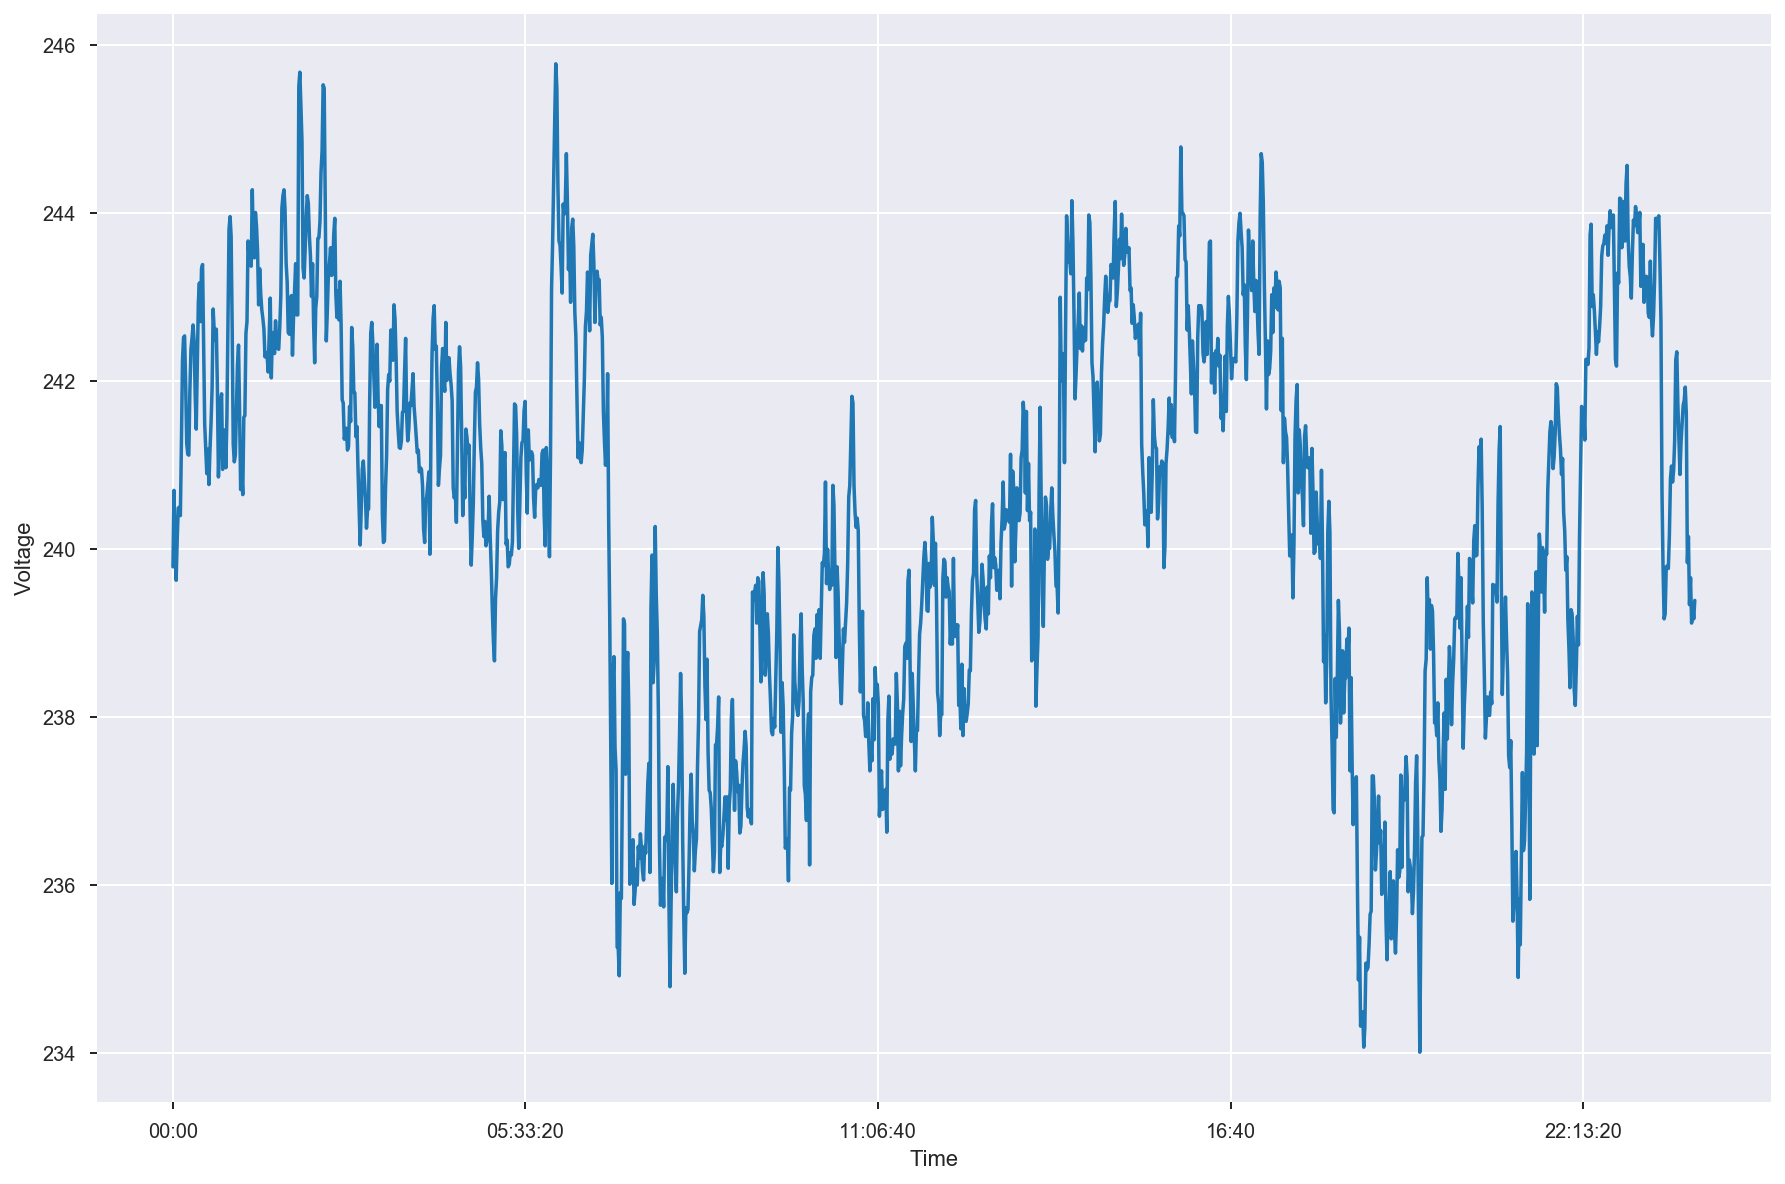

In [82]:
plt.subplots(figsize=(15,10))
sns.lineplot(x='Time',y='Voltage', data = filtered_data)

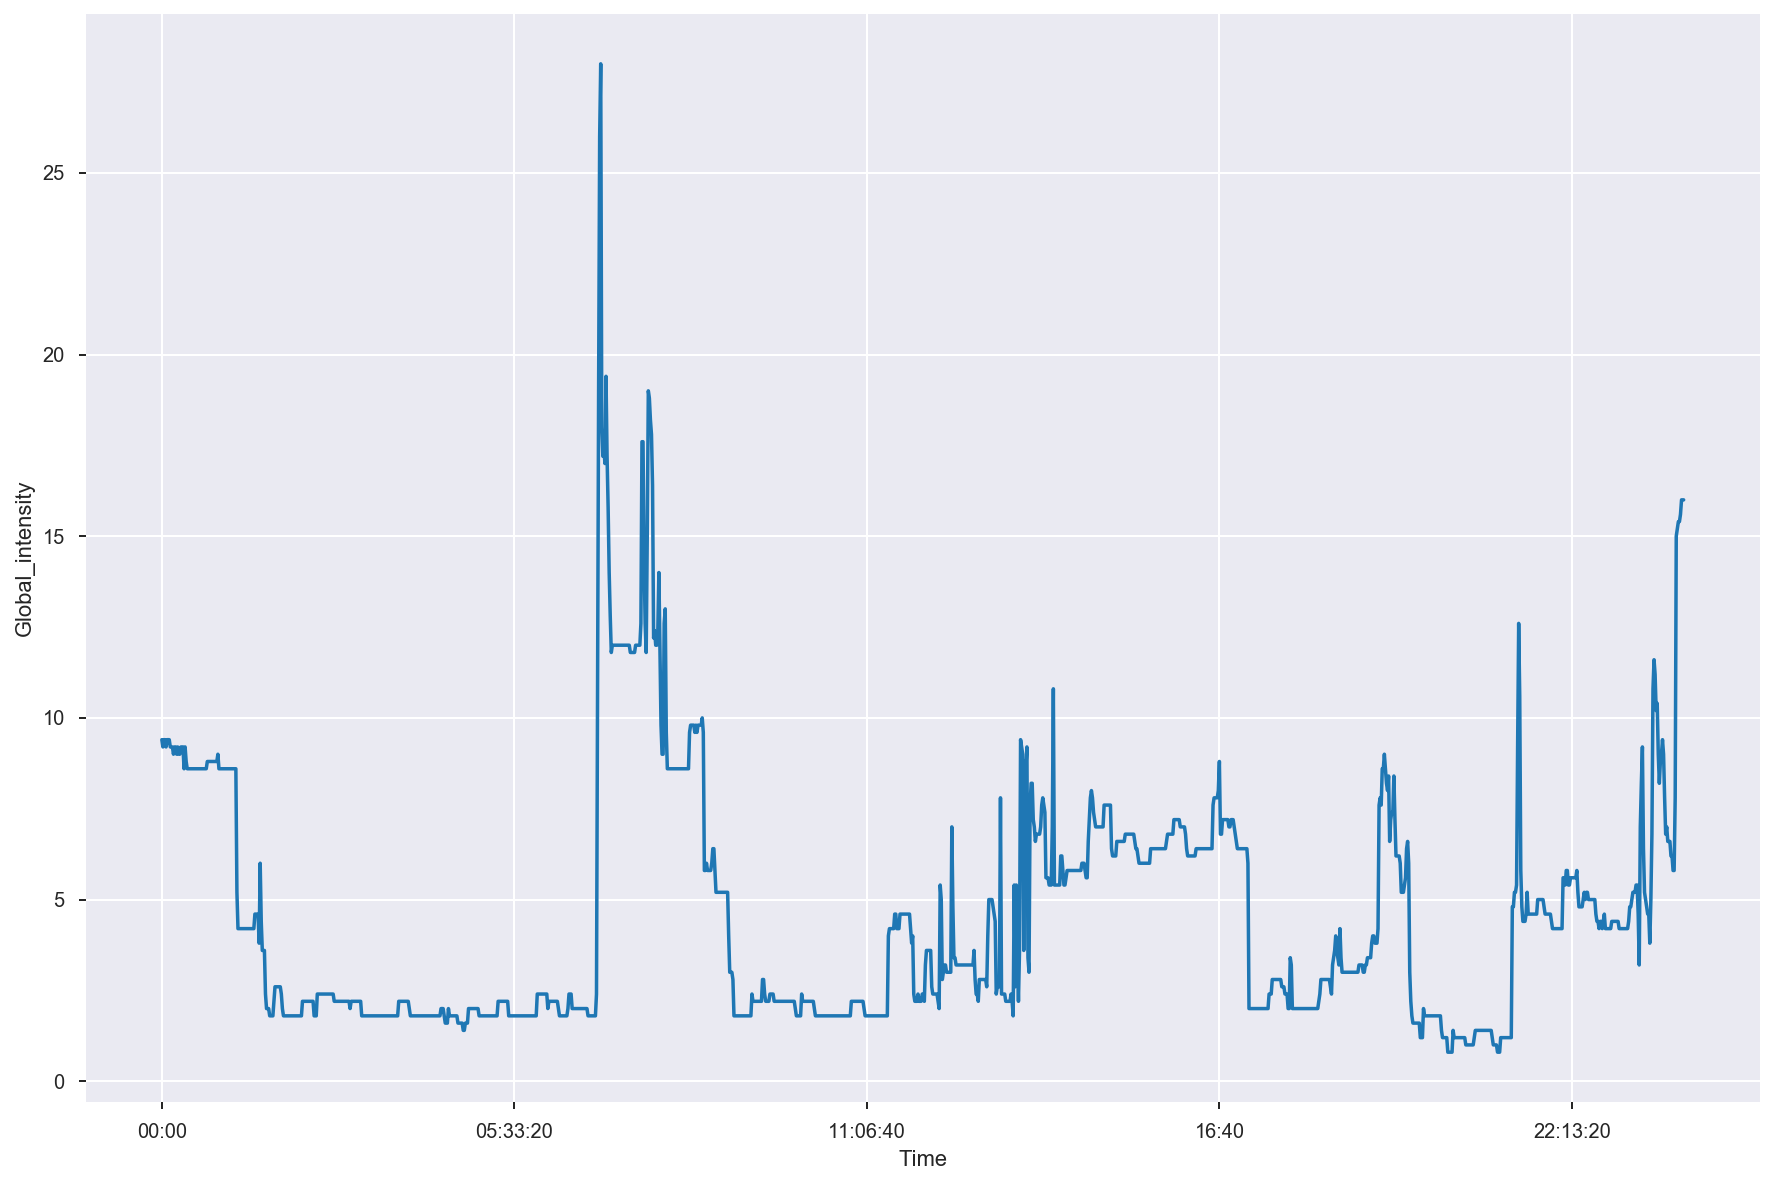

In [84]:
plt.subplots(figsize=(15,10))
sns.lineplot(x='Time',y='Global_intensity', data = filtered_data)

In [86]:
active_energy = (filtered_data['Global_active_power'] * 1000 / 60) - (filtered_data['Sub_metering_1'] +
                                                                      filtered_data['Sub_metering_2'] +
                                                                      filtered_data['Sub_metering_3'])

In [90]:
filtered_data.shape

(1440, 10)

In [92]:
filtered_data['active_energy'] = active_energy

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


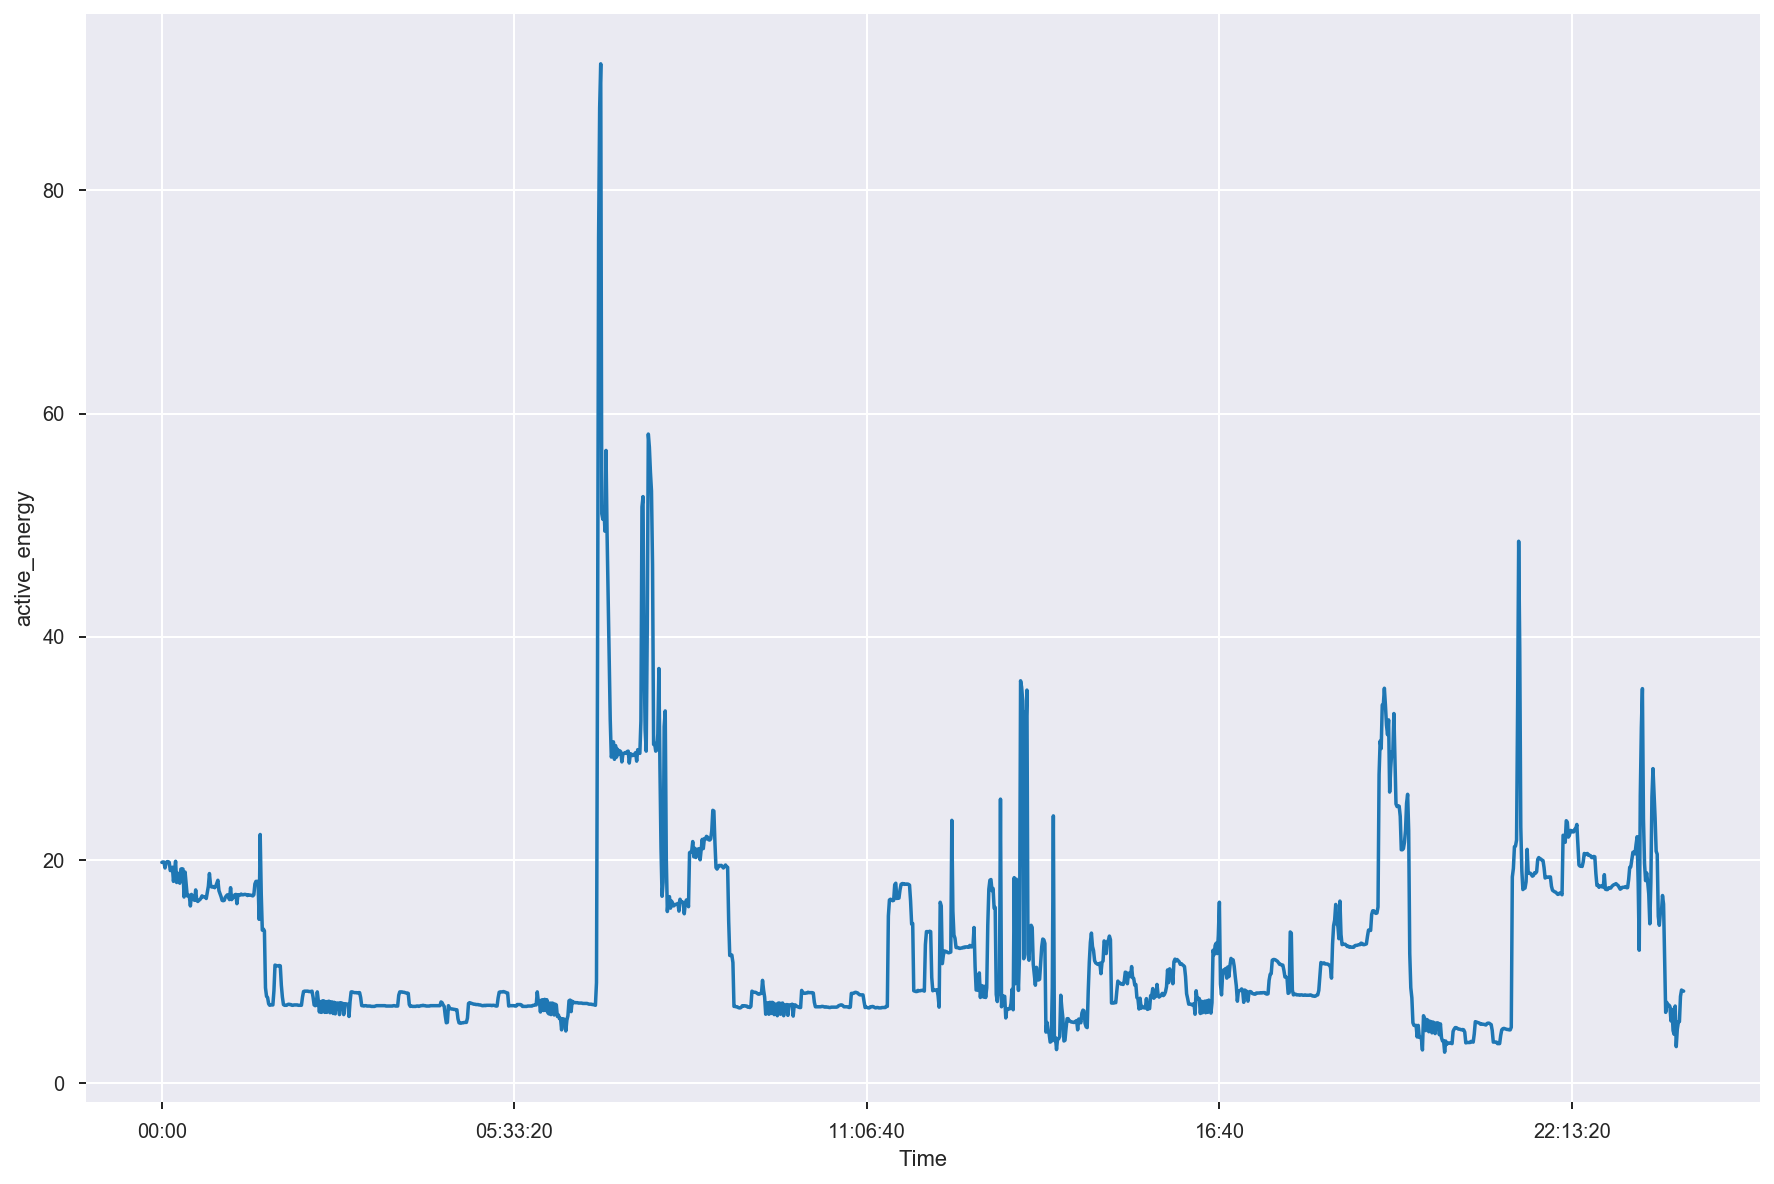

In [94]:
plt.subplots(figsize=(15,10))
sns.lineplot(x='Time',y='active_energy', data = filtered_data)

## detecting dates with abnormal voltage usage

In [101]:
daily_stats_voltage = power_pd_cleaned.groupby('Date').agg({'Voltage':'mean'})

In [102]:
q1 = daily_stats_voltage['Voltage'].quantile(0.25)
q3 = daily_stats_voltage['Voltage'].quantile(0.75)
voltage_iqr = q3 - q1



In [121]:
# Quite extreme outliers
outliers_voltage = daily_stats_voltage.query('(@q1 - 3 * @voltage_iqr) >= Voltage | Voltage>= (@q3 + 3 * @voltage_iqr)')

In [115]:
daily_stats_voltage.Voltage.describe()

count    1433.000000
mean      240.836421
std         2.045493
min       231.088229
25%       240.094778
50%       240.965688
75%       241.878583
max       247.435007
Name: Voltage, dtype: float64

In [126]:
outliers_voltage.index

DatetimeIndex(['2007-04-28', '2007-05-01', '2007-05-06', '2007-05-07',
               '2007-05-12', '2007-05-21', '2007-05-25', '2007-06-02',
               '2007-06-05', '2007-06-06', '2007-06-07', '2007-07-17',
               '2007-07-18', '2007-07-19', '2007-07-21', '2007-07-23',
               '2007-08-03', '2007-08-06', '2007-08-07', '2007-08-08',
               '2007-08-09', '2007-08-10', '2008-06-03', '2008-06-04',
               '2009-05-26', '2009-05-27', '2009-05-28', '2009-12-20'],
              dtype='datetime64[ns]', name='Date', freq=None)

### Correlation

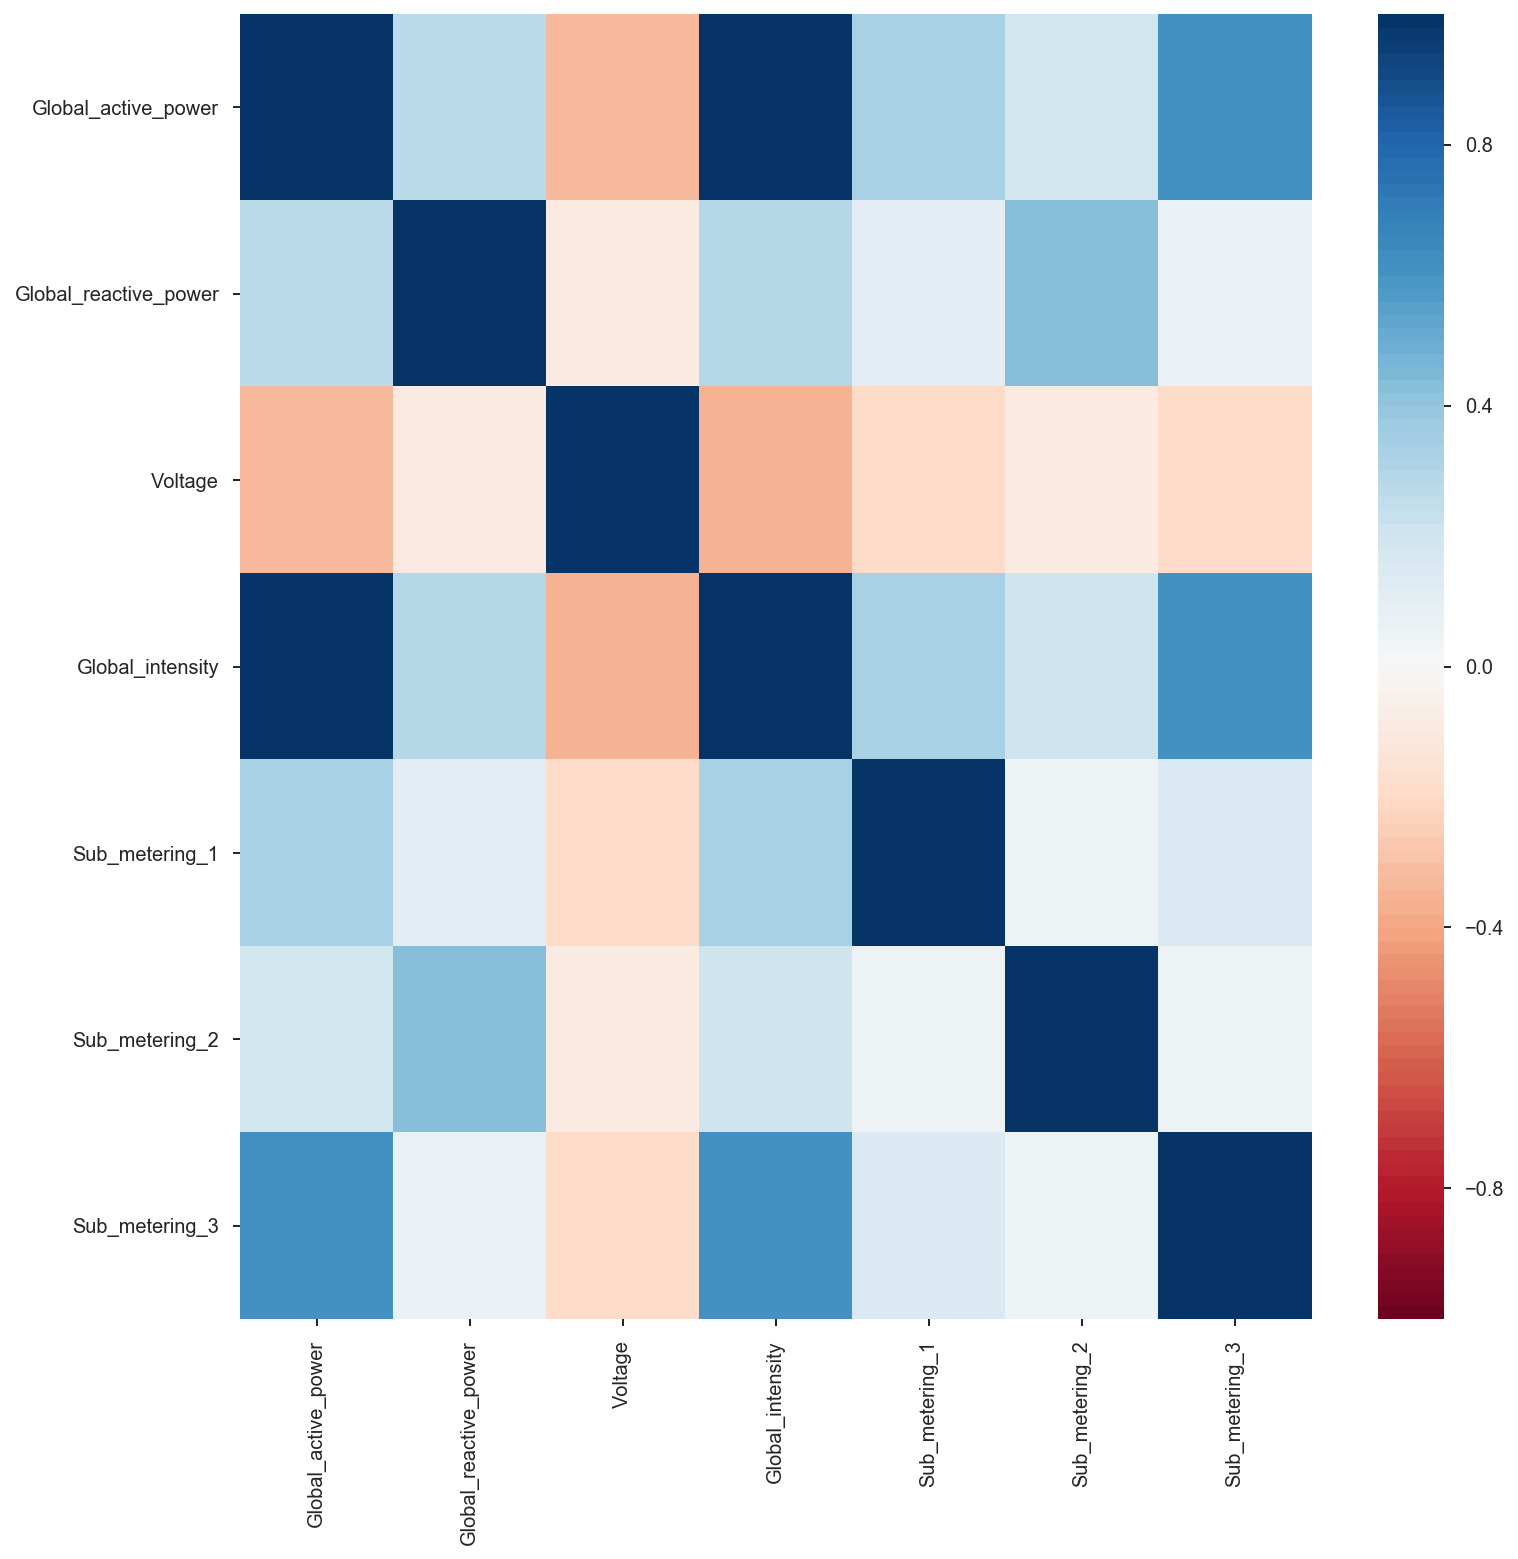

In [132]:
plt.subplots(figsize=(12, 12))

cmap = sns.color_palette("RdBu", n_colors=100)

sns.heatmap(numeric_cols.corr(method='spearman'), vmin=-1, vmax=1, cmap=cmap)

In [136]:
Y = numeric_cols[['Global_active_power']]
X = numeric_cols.drop(['Global_active_power'],axis=1)

In [138]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)

In [144]:
pandas_profiling.ProfileReport(numeric_cols)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


# As for features for the model, rolling windows for different intervals definetely should be created (to capture long-term, short-term trends). Also it would be nice to add season (or month) as a  categorical feature. 

## Final feature generation, lets predict next week power usage

In [276]:
# power_pd.drop(['year_and_month'],axis=1, inplace=True)
power_pd['year_and_week'] = power_pd.Date.dt.year.astype(str).str.cat(power_pd.Date.dt.week.astype(str), sep='-')

In [277]:
power_pd['month'] = power_pd['Date'].dt.month

In [278]:
target = power_pd.groupby('year_and_week').mean()[['Global_active_power']]
target.columns=['target']

In [279]:
month = power_pd.groupby('year_and_week').agg({'month':'mean'}).round()

In [280]:
mean_stats = power_pd.groupby('year_and_week').mean()[numerical_columns.columns]

In [281]:
# Here we are generating sliding window features to get stats from previous weeks as features
features_shifted = [mean_stats.shift(periods=per) for per in [1,2,3]]

In [282]:
for feature in features_shifted:
    target = target.merge(feature, right_index=True, left_index=True)

In [283]:
#Joining month to capture seasonal pattern 
full_df = target.merge(month,right_index=True,left_index=True)

In [284]:
#Remove rows with NA values
full_df = full_df[3:]

In [285]:
splitted_index = full_df.index.str.split('-').str
year= splitted_index.slice(start=0,stop=1).str.join('')
week = splitted_index.slice(1).str.join('')

In [286]:
full_df['year'] = year.astype(int)
full_df['week'] = week.astype(int)

In [287]:
#For sort-of time-based split
full_df.sort_values(['year','week'], inplace=True)
full_df.drop(['year','week'], axis=1, inplace=True)

## Just for fun, lets test RF :)

In [288]:
def rmse(Y_true, Y_test):
    return np.mean(np.sqrt(np.power(Y_true-Y_test,2)))

In [291]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [290]:
rf = RandomForestRegressor(n_estimators=200,max_depth=30,max_features=.8)

In [292]:
features, target = full_df.drop('target',axis=1), full_df[['target']]

In [300]:
X_train, X_test , Y_train , Y_test = train_test_split(features, target, shuffle=False)

In [301]:
rf.fit(X_train, Y_train)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
                      max_features=0.8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [302]:
#R^2 coef
rf.score(X_test, Y_test)

0.5773865391947957

In [303]:
rf.predict(X_test)

array([1.26769361, 1.35844839, 1.18156735, 1.23792698, 1.33846574,
       1.30107243, 1.37669941, 1.32000052, 1.19401636, 1.3252993 ,
       1.17856877, 1.23344523, 1.16886727, 1.26319464, 1.2403825 ,
       1.17835867, 1.05394114, 1.02335609, 1.07875739, 1.11940345,
       1.04010817, 0.95649695, 1.07629081, 1.17599963, 1.08115265,
       1.0754321 , 1.03759253, 1.02442991, 0.95407612, 0.95211628,
       0.87472798, 0.77424772, 0.77705106, 0.88485085, 0.70333223,
       0.48064405, 0.48809266, 0.83111235, 0.87805224, 1.02951357,
       1.07780493, 0.94723886, 0.99056725, 1.21732739, 1.25305714,
       1.06822502, 1.05772304, 1.03888075, 1.18044337, 1.29461312,
       1.12087407, 1.31233856])

In [304]:
#FI 
list(zip(X_train.columns,rf.feature_importances_))

[('Global_active_power_x', 0.18438247316478892),
 ('Global_reactive_power_x', 0.033945204661111616),
 ('Voltage_x', 0.017208532732328648),
 ('Global_intensity_x', 0.09589988535848869),
 ('Sub_metering_1_x', 0.06594731330625471),
 ('Sub_metering_2_x', 0.011808274353799077),
 ('Sub_metering_3_x', 0.016357087212867265),
 ('Global_active_power_y', 0.06449451829112782),
 ('Global_reactive_power_y', 0.05418615200220404),
 ('Voltage_y', 0.021911142269579423),
 ('Global_intensity_y', 0.04713782732067787),
 ('Sub_metering_1_y', 0.011647784427565018),
 ('Sub_metering_2_y', 0.022193615686596224),
 ('Sub_metering_3_y', 0.017308402634899616),
 ('Global_active_power', 0.019570210907884078),
 ('Global_reactive_power', 0.03491516279872261),
 ('Voltage', 0.01778928805056569),
 ('Global_intensity', 0.02207124690420505),
 ('Sub_metering_1', 0.013361184908490942),
 ('Sub_metering_2', 0.016540667781150944),
 ('Sub_metering_3', 0.018322909837182613),
 ('month', 0.1930011153895093)]

In [305]:
rmse(rf.predict(X_test),Y_test.values.flatten())

0.1453328163911934

## Not bad as for a baseline